# Probabilistic forecasting: Calibration and Sharpness

**Calibration**: statistical consistency between the distributional forecasts (joint property of the predictions and the events that materialize).

**Sharpness**: Concentration of the predictive distributions (property of the forecasts only).

Tools for checking calibration and sharpness: probability integral transform (PIT) histogram, marginal calibration plot, sharpness diagram, and proper scoring rules.

## 1. Theoretical Framework 
In the setting of probabilistic forecasting, the data-generating process (the **G**roundtruth) and the **F**orecast are represented as cummulative distribution functions (CDFs) $G_{t}$ and $F_{t}$, respectively, for a given (usually discrete) index set $t \in \{1, 2, ... \}$. 

The data-generating process encoded via the CDFs $G_{t}$ remains unobservale at any point in time. However, the realization $x_{t} \in \mathbb{R}^{d}$ of the random variable $X_{t} \sim G_{t}$ becomes available to the observer at time $t$.

Key question is how to evaluate if a probabilistic forecast $F_{t}$ is properly selected as compared to a hidden probabilistic law $G_{t}$ which only materializes into a single observation $x_{t}$.    

### Example: Weather Forecasting
For simplicity, the data-generating process is given by a two-staged sampling mechanism. First, a mean is sampled $\mu_{t} \sim \mathcal{N}(0, 1)$, and then the observation $G_{t} = \mathcal{N}(\mu_{t}, 1)$.

Now postulate four different forecastsers with varying degree of insights on the data-generating process behind $G_{t}$.

- **Ideal:**            $\qquad \qquad \qquad \; \mathcal{N}(\mu_{t}, 1)$
- **Climatological:**   $\qquad \quad \mathcal{N}(0, 2)$
- **Unfocused:** $\qquad \qquad \; \frac{1}{2} \left( \mathcal{N}(\mu_{t}, 1) + \mathcal{N}(\mu_{t} + \tau_{t}, 1) \right)$ with $\tau_{t} = 1$ or $\tau_{t} = -1$, equal probability.
- **Hamill's**:  $\qquad \qquad \quad \mathcal{N}(\mu_{t} + \delta_{t}, \sigma_{t}^{2})$ with 
$(\delta_{t}, \sigma_{t}^{2}) \sim \left( \frac{1}{2}, 1 \right)$,  $\left( -\frac{1}{2}, 1 \right)$, and $\left(0, \frac{169}{100} \right)$ equal probability. 

In an actual forecasting setting, only climatology is attainable as the other three forecasters require knowledge on the unobservable process $(\mu_{t})_{t}$. 

In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate, stats
from scipy.optimize import minimize
import random
import properscoring as ps
from statsmodels import tsa, graphics
import statsmodels.tsa

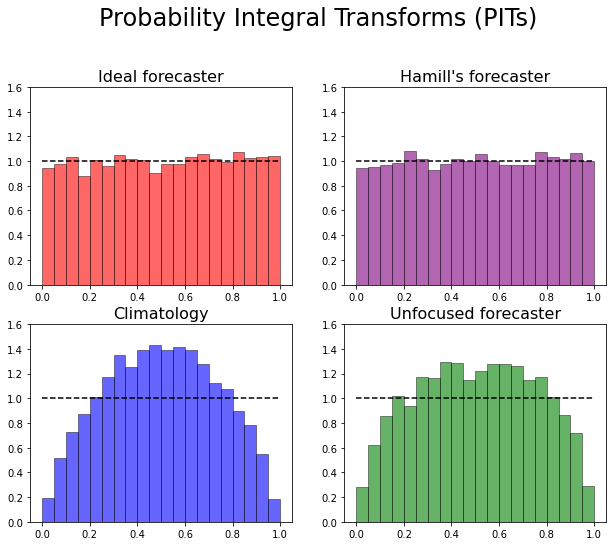

In [39]:
N = 10000
np.random.seed(177)

# Parameters 
mu  = np.random.normal(loc = 0,  scale = 1, size = N)
tau = np.random.choice(a = [-1, 1], size = N)
delta = np.random.choice(a = [0.5, -0.5, 0], size = N)
sigma_square = [100/169 if delta_t == 0 else 1 for delta_t in delta]

# sample observations
x   = np.random.normal(loc = mu, scale = 1, size=None)

# CDFs
F_Ideal  = lambda x_t, mu_t: scipy.stats.norm.cdf(x = np.asarray(x_t), loc = np.asarray(mu_t), scale = 1)
F_Climat = lambda x_t: scipy.stats.norm.cdf(x = np.asarray(x_t), loc = 0, scale = 2)
F_Unfoc  = lambda x_t, mu_t, delta_t: 0.5*scipy.stats.norm.cdf(x = np.asarray(x_t), loc = np.asarray(mu_t), scale = 1) + 0.5 * scipy.stats.norm.cdf(x = np.asarray(x_t), loc = np.asarray(mu_t) + np.array(tau)[0:x_t.size], scale = 1)
F_Hamill = lambda x_t, mu_t, delta_t, sigma_square_t: (1./ 3) * scipy.stats.norm.cdf(x = np.asarray(x_t), loc = np.asarray(mu_t) + 0.5, scale = 1) +  \
                                                      (1./ 3) * scipy.stats.norm.cdf(x = np.asarray(x_t), loc = np.asarray(mu_t) - 0.5, scale = 1) + \
                                                      (1./ 3) * scipy.stats.norm.cdf(x = np.asarray(x_t), loc = np.asarray(mu_t), scale = 169/100)

# Density functions
f_Ideal   = lambda x_t, mu_t: scipy.stats.norm.pdf(x = np.asarray(x_t), loc = np.asarray(mu_t), scale = 1)
f_Climat  = lambda x_t: scipy.stats.norm.pdf(x = np.asarray(x_t), loc = 0, scale = 2)
f_Unfoc   = lambda x_t, mu_t, delta_t: 0.5*scipy.stats.norm.pdf(x = np.asarray(x_t), loc = np.asarray(mu_t), scale = 1) + 0.5 * scipy.stats.norm.pdf(x = np.asarray(x_t), loc = np.asarray(mu_t) + np.array(tau), scale = 1)
f_Hamill  = lambda x_t, mu_t, delta_t, sigma_square_t: (1./ 3) * scipy.stats.norm.pdf(x = np.asarray(x_t), loc = np.asarray(mu_t) + 0.5, scale = 1) +  \
                                                       (1./ 3) * scipy.stats.norm.pdf(x = np.asarray(x_t), loc = np.asarray(mu_t) - 0.5, scale = 1) + \
                                                       (1./ 3) * scipy.stats.norm.pdf(x = np.asarray(x_t), loc = np.asarray(mu_t), scale = 169/100)


# Plot
fc_Names     = ['Ideal forecaster', 'Climatology', 'Hamill\'s forecaster', 'Unfocused forecaster']
fc_CDFs      = [F_Ideal, F_Climat, F_Unfoc, F_Hamill]
fc_Arguments = [[x, mu], [x], [x, mu, delta], [x, mu, delta, sigma_square]]
fc_Colors    = ['red', 'blue', 'purple', 'green'] 

# panel of 2x2 plots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(left = 0.1)

# fill-in histogram plots 
N_bins = 20
ylim   = (0, 1.6)
fig.suptitle('Probability Integral Transforms (PITs)', fontsize = 24, y = 1.02)
for name_loc, CDF_loc, args_loc, i_loc, col_loc in zip(fc_Names, fc_CDFs, fc_Arguments, range(len(fc_Names)), fc_Colors):
    # sublplot index
    (k, l) = (i_loc % 2, i_loc // 2)
    # plot
    axs[k,l].set_title(name_loc, fontsize = 16)
    axs[k,l].set_ylim(ylim)
    axs[k,l].hist(CDF_loc(*args_loc), bins = N_bins, density = True, range=(0, 1), color = col_loc, 
                  lw=0, alpha= 0.6, edgecolor='black', linewidth = 0.7)
    axs[k,l].hlines(y = 1, xmin = 0, xmax = 1, color = 'black', linestyles ='dashed')
plt.show()

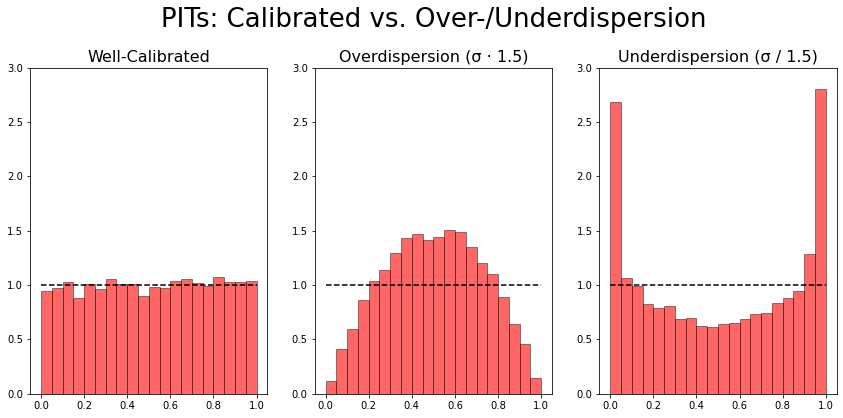

In [7]:
dispMult = 1.5

F_Overdispersed   = lambda x_t, mu_t: scipy.stats.norm.cdf(x = np.asarray(x_t), loc = np.asarray(mu_t), scale = dispMult)
F_Underdispersed  = lambda x_t, mu_t: scipy.stats.norm.cdf(x = np.asarray(x_t), loc = np.asarray(mu_t), scale = 1./dispMult)

fc_disp_Names     = ['Well-Calibrated', 'Overdispersion (σ ⋅ ' + str(dispMult) + ')', 'Underdispersion (σ / ' + str(abs(dispMult)) + ')']
fc_disp_CDFs      = [F_Ideal, F_Overdispersed, F_Underdispersed]
fc_disp_Arguments = [[x, mu]] * len(fc_CDFs)
                
# panel of 2x2 plots
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
fig.subplots_adjust(left = 0.1)

# fill-in histogram plots 
ylim = (0, 3.0)
fig.suptitle('PITs: Calibrated vs. Over-/Underdispersion', fontsize = 26, y = 1.02)
for name_loc, CDF_loc, args_loc, i in zip(fc_disp_Names, fc_disp_CDFs, fc_disp_Arguments, range(len(fc_disp_Names))):
    # plot
    axs[i].set_title(name_loc, fontsize = 16)
    axs[i].set_ylim(ylim)
    axs[i].hist(CDF_loc(*args_loc), bins = N_bins, density = True, range=(0, 1), color = "red", 
                  lw=0, alpha= 0.6, edgecolor='black', linewidth = 0.7)
    axs[i].hlines(y = 1, xmin = 0, xmax = 1, color = 'black', linestyles ='dashed')
plt.show()

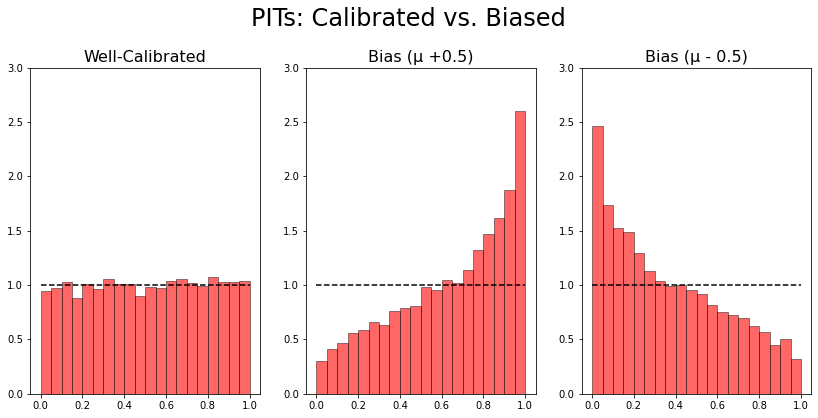

In [8]:
# Bias (modulus)
biasEps = 0.5

F_BiasUp    = lambda x_t, mu_t: scipy.stats.norm.cdf(x = np.asarray(x_t), loc = np.asarray(mu_t) - biasEps, scale = 1)
F_BiasDown  = lambda x_t, mu_t: scipy.stats.norm.cdf(x = np.asarray(x_t), loc = np.asarray(mu_t) + biasEps, scale = 1)

fc_bias_Names     = ['Well-Calibrated', 'Bias (μ +' + str(biasEps) + ')', 'Bias (μ - ' + str(abs(biasEps)) + ')']
fc_bias_CDFs      = [F_Ideal, F_BiasUp, F_BiasDown]
fc_bias_Arguments = [[x, mu]] * len(fc_CDFs)
                
# panel of 2x2 plots
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
#fig.subplots_adjust(left = 0.1)

# fill-in histogram plots 
ylim = (0, 3.0)
fig.suptitle('PITs: Calibrated vs. Biased', fontsize = 24, y = 1.02)
for name_loc, CDF_loc, args_loc, i in zip(fc_bias_Names, fc_bias_CDFs, fc_bias_Arguments, range(len(fc_bias_Names))):
    # plot
    axs[i].set_title(name_loc, fontsize = 16)
    axs[i].set_ylim(ylim)
    axs[i].hist(CDF_loc(*args_loc), bins = N_bins, density = True, range=(0, 1), color = "red", 
                  lw=0, alpha= 0.6, edgecolor='black', linewidth = 0.7)
    axs[i].hlines(y = 1, xmin = 0, xmax = 1, color = 'black', linestyles ='dashed')
plt.show()

## 2. Modes of Calibration
The paper introduces four modes of calibration that are defined as follows:

### Theorem 1
(a) The sequence $(F_{t})_{t=1,2,...}$ is **probabilistically callibrated** w.r.t. to $(G_{t})_{t=1,2,...}$ if
$$ \frac{1}{T} \sum_{t=1}^{T}G_{t} \circ F^{-1}_{t}(p) \rightarrow p \; \mbox{, } \qquad p \in (0,1)$$

(b) The sequence $(F_{t})_{t=1,2,...}$ is **exceedance callibrated** w.r.t. to $(G_{t})_{t=1,2,...}$ if
$$ \frac{1}{T} \sum_{t=1}^{T}G^{-1}_{t} \circ F_{t}(x) \rightarrow x \; \mbox{, } \qquad x \in \mathbb{R}^{d}$$

(c) The sequence $(F_{t})_{t=1,2,...}$ is **marginally callibrated** w.r.t. to $(G_{t})_{t=1,2,...}$ if
the limits
\begin{align}
     \bar{G}  &= \lim \limits_{T \to \infty} \left( \frac{1}{T} \sum_{t=1}^{T} G_{t} \right) \\
     \bar{F}  &= \lim \limits_{T \to \infty} \left( \frac{1}{T} \sum_{t=1}^{T} F_{t} \right)
\end{align}
exist and it holds 
$$  \bar{G}(x) =  \bar{F}(x)$$
for all $x \in \mathbb{R}^{d}$.

(d) The sequence $(F_{t})_{t=1,2,...}$ is **strongly callibrated** w.r.t. to $(G_{t})_{t=1,2,...}$ if it is probabilistically calibrated, exceedance calibrated, and marginally calibrated.

## 3. Diagnostic Tools

### 3.1. Assessing probabilistic calibration

#### Theorem 2
Let $(F_{t})_{t=1,2,...}$ and $(G_{t})_{t=1,2,...}$ be sequences of continuous, strictly increasing CDFs. Define $F_{t}(x_{t}) = p_{t}$. Suppose that $X_{t}$ has CDF $G_{t}$ and that $(X_{t})_{t}$ is a $*$-mixing sequence of random variables. Then, it holds
$$  \frac{1}{T} \sum_{t=1}^{T} \mathbb{1} (p_{t} \leq p) \to p $$
if and only if $(F_{t})_{t}$ is probabilistically calibrated w.r.t. $(G_{t})_{t}$.

In [9]:
coverage_50_List = []
coverage_90_List = []
for name_loc, CDF_loc, args_loc, i_loc in zip(fc_Names, fc_CDFs, fc_Arguments, range(len(fc_Names))):
    # compute coverage 
    coverage_50 = len(CDF_loc(*args_loc)[(CDF_loc(*args_loc) >= 0.25) & (CDF_loc(*args_loc) <= 0.75)]) / len(CDF_loc(*args_loc))
    coverage_90 = len(CDF_loc(*args_loc)[(CDF_loc(*args_loc) >= 0.05) & (CDF_loc(*args_loc) <= 0.95)]) / len(CDF_loc(*args_loc))
    
    # append
    coverage_50_List.append(str(round(100*coverage_50, 2)) + '%')
    coverage_90_List.append(str(round(100*coverage_90, 2)) + '%')
    
    
    
coverageFrame = pd.DataFrame(data  = {'50%' : coverage_50_List, '90%' : coverage_90_List},
                             index = [fc_Name.split(' ')[0] for fc_Name in fc_Names])
coverageFrame.index.name = 'Forecaster'

coverageFrame.style.set_caption("Empirical coverage of central prediction intervals in the simulation study")

,50%,90%
Forecaster,,
Ideal,50.0%,90.08%
Climatology,65.96%,98.13%
Hamill's,49.48%,90.3%
Unfocused,61.22%,97.17%


### 3.2 Assessing Marginal Calibration 
Define the mean CDFs $\bar{F}_{T} := \frac{1}{T} \sum_{t=1}^{T} F_{t}$ and $\bar{G}_{T} := \frac{1}{T} \sum_{t=1}^{T} G_{t}$.

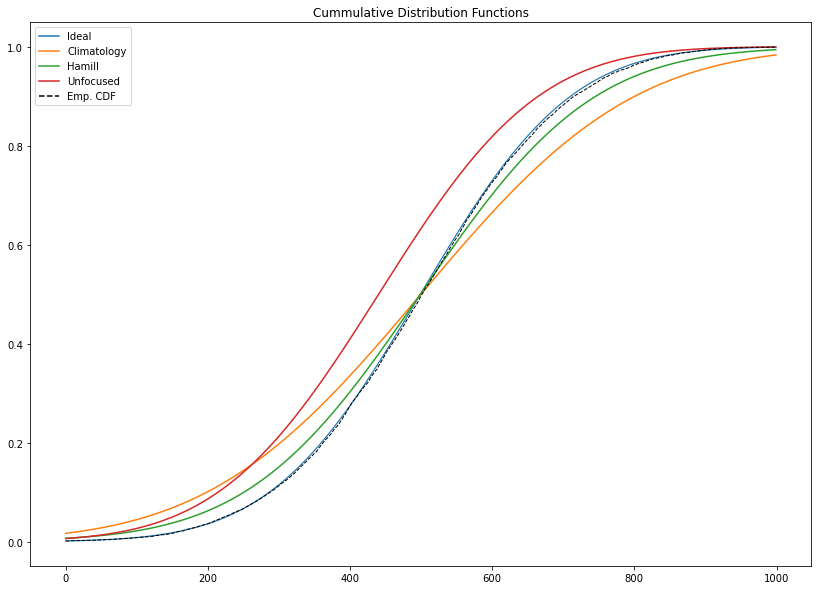

In [10]:
# F_bar
F_Ideal_Bar       = lambda x : np.mean(F_Ideal(mu_t = mu, x_t = x))
F_Climat_Bar      = lambda x : np.mean(F_Climat(x_t = x))
F_Unfoc_Bar       = lambda x : np.mean(F_Unfoc(mu_t = mu, delta_t = delta, x_t = x))
F_Hamill_Bar      = lambda x : np.mean(F_Hamill(mu_t = mu, delta_t = delta, sigma_square_t = sigma_square, 
                                               x_t = x))
G_Hat             = lambda x_loc : (1.0 / len(x)) * np.sum([1 if x_loc >= x_ else 0 for x_ in x])

F_Ideal_BarList  = []
F_Climat_BarList = []
F_Hamill_BarList = []
F_Unfoc_BarList  = []
G_HatList        = []

# grid 
x_grid = np.linspace(np.quantile(x, 0.001), np.quantile(x, 0.999), 1000)

# loop
fc_CDFs_Bar       = [F_Ideal_Bar, F_Climat_Bar, F_Unfoc_Bar, F_Hamill_Bar] 
fc_Arguments_Bar  = [[x_grid, mu], [x_grid], [x_grid, mu, delta], [x_grid, mu, delta, sigma_square]]

# compute CDF values for x_grid
for x_ in x_grid:
    F_Ideal_BarList.append(F_Ideal_Bar(x_))
    F_Climat_BarList.append(F_Climat_Bar(x_))
    F_Hamill_BarList.append(F_Hamill_Bar(x_))
    F_Unfoc_BarList.append(F_Unfoc_Bar(x_))
    G_HatList.append(G_Hat(x_))
    
# CDF Summary Frame
CDF_Frame = pd.DataFrame({'Ideal'       : F_Ideal_BarList, 
                          'Climatology' : F_Climat_BarList, 
                          'Hamill'      : F_Hamill_BarList,
                          'Unfocused'   : F_Unfoc_BarList,
                          'Emp. CDF'    : G_HatList})

# CDF Difference Frame 
Delta_CDF_Frame = pd.DataFrame({'Ideal'       : np.asarray(F_Ideal_BarList)  - np.asarray(G_HatList), 
                                'Climatology' : np.asarray(F_Climat_BarList) - np.asarray(G_HatList), 
                                'Hamill'      : np.asarray(F_Hamill_BarList) - np.asarray(G_HatList),
                                'Unfocused'   : np.asarray(F_Unfoc_BarList)  - np.asarray(G_HatList)})

# Plot
styles=['-', '-', '-', '-', 'k--']
lws = [1.2, 1.5, 1.5, 1.5, 1.0]

ax = CDF_Frame.plot(style=styles, figsize = (14, 10), title = 'Cummulative Distribution Functions')
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=lws[i])

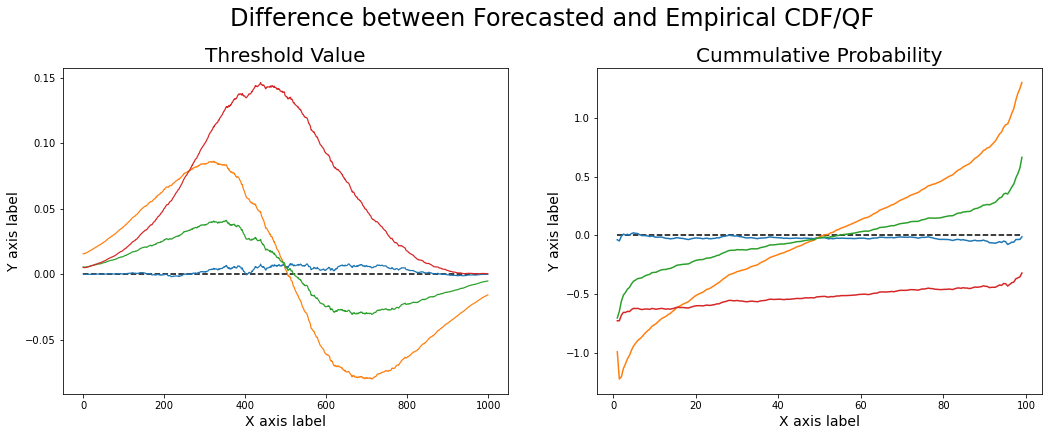

In [11]:
# Interpolated CDFs
F_Ideal_interp  = scipy.interpolate.interp1d(x=x_grid, y=np.asarray(CDF_Frame['Ideal']))
F_Climat_interp = scipy.interpolate.interp1d(x=x_grid, y=np.asarray(CDF_Frame['Climatology']))
F_Hamill_interp = scipy.interpolate.interp1d(x=x_grid, y=np.asarray(CDF_Frame['Hamill']))
F_Unfoc_interp  = scipy.interpolate.interp1d(x=x_grid, y=np.asarray(CDF_Frame['Unfocused']))
G_Hat_interp    = scipy.interpolate.interp1d(x=x_grid, y=np.asarray(CDF_Frame['Emp. CDF']))

# 
NamesList       = [fc_Name.split(' ')[0] for fc_Name in fc_Names] + ['Emp. CDF']
x_grid_ref      = np.linspace(np.min(x_grid), np.max(x_grid), 10000)
q_grid          = np.linspace(0.01, .99, 200)
quantFrame      = pd.DataFrame()
for (F_CDF, name_) in zip([F_Ideal_interp, F_Climat_interp, F_Hamill_interp, F_Unfoc_interp, G_Hat_interp], NamesList):
    # compute 
    F_val = F_CDF(x_grid_ref)
    
    # compute inverse
    F_ = [np.nanmin([x_val_loc if F_val_loc >= q_loc else np.inf for (F_val_loc, x_val_loc) in zip(F_val, x_grid_ref)]) for q_loc in q_grid]
    
    # append df 
    quantFrame[name_] = F_
    
# replace inf
quantFrame.replace([np.inf, -np.inf], np.nan, inplace=True)
    
# columns 
for cName in list(quantFrame.columns):
    # copy data
    if(quantFrame[cName].isna().any()):
        data_vec = np.array(quantFrame[cName])

        # index 
        nanIndex = [i_loc if flag else np.nan for (flag, i_loc) in zip(list(np.isnan(data_vec)), range(1, len(data_vec) + 1, 1))]
        nanIndex = [elem for elem in nanIndex if elem==elem]

        # interpolation 
        interpolIndex = range(np.min(nanIndex) - 11, np.min(nanIndex) - 1, 1)
        x_inter       = np.linspace(np.min(nanIndex) - 11, np.min(nanIndex) - 1, 10)
        y_inter       = np.array(np.log(np.array(data_vec[interpolIndex])))
        # - interpolate log quantiles
        spl           = scipy.interpolate.InterpolatedUnivariateSpline(x_inter, y_inter)

        # extrapolate to NaN values 
        extrapolIndex = range(np.min(nanIndex)-1, len(quantFrame), 1)
        x_extra       = np.linspace(np.min(nanIndex), np.max(nanIndex), len(nanIndex))
        np.exp(spl(x_extra))

        # replace NaN with extrapolated 
        data_vec[np.isnan(data_vec)] = np.exp(spl(x_extra))
        quantFrame[cName] = data_vec
        
        
# CDF Difference Frame 
Delta_Quant_Frame = pd.DataFrame(data = {'Ideal'       : np.asarray(quantFrame['Ideal'])       - np.asarray(quantFrame['Emp. CDF']), 
                                         'Climatology' : np.asarray(quantFrame['Climatology']) - np.asarray(quantFrame['Emp. CDF']), 
                                         'Hamill'      : np.asarray(quantFrame['Hamill\'s'])   - np.asarray(quantFrame['Emp. CDF']),
                                         'Unfocused'   : np.asarray(quantFrame['Unfocused'])   - np.asarray(quantFrame['Emp. CDF'])},
                                index = [q_ * 100 for q_ in q_grid])



# Panel: 2x2 plots
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
fig.subplots_adjust(left = 0.1)

# styles
styles=['-', '-', '-', '-', 'k--']
lws = [1.2, 1.2, 1.2, 1.2, 1.5]

fig.suptitle('Difference between Forecasted and Empirical CDF/QF', fontsize = 24, y = 1.02)
for (frame_loc, name_loc, i_loc)  in zip([Delta_CDF_Frame, Delta_Quant_Frame], ['Threshold Value', 'Cummulative Probability'], range(2)):
    axs[i_loc].plot(frame_loc)
    axs[i_loc].set_title(name_loc, fontsize = 20)
    axs[i_loc].hlines(y = 0, xmin = np.min(frame_loc.index), xmax = np.max(frame_loc.index), color = 'black', linestyles ='dashed')
    if(name_loc != 'Cummulative Probability'):
        for i, l in enumerate(axs[i_loc].lines):
            axs[i_loc].set_xlabel("X axis label", fontsize = 14)
            axs[i_loc].set_ylabel("Y axis label", fontsize = 14)
            plt.setp(l, linewidth=lws[i])
    # Labels
    axs[i_loc].set_xlabel("X axis label", fontsize = 14)
    axs[i_loc].set_ylabel("Y axis label", fontsize = 14)
plt.show()

### 3.3 Assessing Sharpness
Sharpness refers to the concentration of the predictive distributions It is a property of the
forecasts only. The width of prediction intervals is assessed via graphical summaries and metrics.

A metric is the (average) width of the central predictive interval. These intervals are computed below based either on a readily quantile function (for *Ideal* and *Climatology*) or numerical inversion (via `scipy optimize`) for *Hamill's* and *Unfocused*. 

In [12]:
%%time 

# closed-form inverse of CDFs
Q_Ideal  = lambda q_t, mu_t: scipy.stats.norm.ppf(q = np.asarray(q_t), loc = np.asarray(mu_t), scale = 1)
Q_Climat = lambda q_t: scipy.stats.norm.ppf(q = np.asarray(q_t), loc = 0, scale = 2)

# numerical inverse of CDFs
Hammill_Width_50 = []
Hammill_Width_90 = []

Unfoc_Width_50 = []
Unfoc_Width_90 = []

# loop: only every 4th entry to speed up computation 
for t in range(0, len(mu), 4):
    # - key quantiles 
    Hamill_quant = []
    Unfoc_quant  = []
    for quant in [0.75, 0.25, 0.9, 0.1]:
        Q_Unfoc   = lambda x : (F_Unfoc(x,   mu_t = mu[t], delta_t = delta[t]) - quant)**2
        Q_Hamill  = lambda x : (F_Hamill(x,  mu_t = mu[t], delta_t = delta[t], sigma_square_t = sigma_square[t]) - quant)**2
        
        Hamill_quant.append(float(scipy.optimize.minimize(fun = Q_Hamill, x0 = 0.0)['x']))
        Unfoc_quant.append(float(scipy.optimize.minimize(fun  = Q_Unfoc,  x0 = 0.0)['x']))
        
    # compute width
    Hammill_Width_50.append(Hamill_quant[0] - Hamill_quant[1])
    Hammill_Width_90.append(Hamill_quant[2] - Hamill_quant[3])
    Unfoc_Width_50.append(Unfoc_quant[0] - Unfoc_quant[1])
    Unfoc_Width_90.append(Unfoc_quant[2] - Unfoc_quant[3])
    
# Frame
width_50_List = [np.mean(Q_Ideal(0.75, mu) - Q_Ideal(0.25, mu)),
                 np.mean(Q_Climat(0.75) - Q_Climat(0.25)),
                 np.mean(Hammill_Width_50),
                 np.mean(Unfoc_Width_50)]


width_90_List = [np.mean(Q_Ideal(0.95, mu) - Q_Ideal(0.05, mu)),
                 np.mean(Q_Climat(0.95) - Q_Climat(0.05)),
                 np.mean(Hammill_Width_90),
                 np.mean(Unfoc_Width_90)]

# print
widthFrame = pd.DataFrame(data  = {'50%' : width_50_List, '90%' : width_90_List},
                          index = [fc_Name.split(' ')[0] for fc_Name in fc_Names])
widthFrame.index.name = 'Forecaster'

widthFrame.style.set_caption("Average width for the following intervals:")

CPU times: user 2min, sys: 28.4 ms, total: 2min
Wall time: 2min


,50%,90%
Forecaster,,
Ideal,1.348980,3.289707
Climatology,2.697959,6.579415
Hamill's,1.730687,3.393025
Unfocused,1.672686,3.123852


### 3.4 Proper Scoring Rules 

Scoring rules assign numerical scores to probabilistic forecasts and constitute summary
measures of predictive performance in that <u>they address calibration and sharpness simultaneously</u>. 
A scoring rule $s$ assigns a score to a predictive distribution $F$ and an observation $x$, i.e.
$$ s : (\mathcal{F}, \mathbb{R}) \rightarrow \mathbb{R}, \; (F, x) \mapsto s(F, x) $$

**Brier score**
The Brier score is a (strictly) proper scoring rule applicable for classification problems, i.e. when probabilities are to be assigned to a set of mutually exclusive discrete outcomes. It is defined as
$$ BS(y) = \frac{1}{T} \sum_{t=1}^{T}(F_{t}(y) - \mathbb{1}(x_{t} \leq y)^{2} \mbox{.}$$
Moreover, the Brier skill score is derived from the Brier score. 

**Continuous ranked probability score**
The CRPS is a (strictly) proper scoring rule for continuous predictive distributions. It is defined as (and can be equaviallently by) 
\begin{align}
CRPS(F, x)  &:= \int_{-\infty}^{+\infty}(F(y) - \mathbb{1}(y \geq x))^{2} \mbox{d}y \\
            &= \mathbb{E}_{F} [ X-x ] - \frac{1}{2} \mathbb{E} [ X-X^{\prime}] \\
            &= \int_{-\infty}^{+\infty}BS(y)\mbox{d}y \\
            & \approx \frac{1}{K} \sum_{k = 1}^{K}BS(y_{k})
\end{align}
with $X^{\prime}, X \sim F$ and $y_{1} < ... < y_{K}$. 
The second representation, on the other hand, was established by [Gneiting and Raftery (2007)](https://courses.cs.duke.edu//spring17/compsci590.2/Gneiting2007jasa.pdf). 
The third equality indicates that the CRPS can be expressed as the average of Brier scores (for the binary event that $x \leq y)$ for a range of $y$'s spanning the real line with infinitisimal gaps in between them. The discretized version of this representation will be leveraged below.

In [13]:
# Indicator Function 
I = lambda x, y : (1 if x <= y else 0)

# Brier Scores 
BS_Ideal  = lambda y, x_t, mu_t: np.mean([(F_Ideal(y, mu_) - I(x_, y))**2 for (x_, mu_) in zip(x_t, mu_t)]) 
BS_Climat = lambda y, x_t: np.mean([(F_Climat(y) - I(x=x_, y=y))**2 for x_ in x_t]) 
BS_Hamill = lambda y, x_t, mu_t, delta_t, sigma_square_t: np.mean([(F_Hamill(y, mu_, delta_, sigma_square_) - I(x=x_, y=y))**2 for (x_, mu_, delta_, sigma_square_) in zip(x_t, mu_t, delta_t, sigma_square_t)]) 
BS_Unfoc  = lambda y, x_t, mu_t, delta_t: np.mean([(F_Unfoc(y, mu_, delta_) - I(x=x_, y=y))**2 for (x_, mu_, delta_) in zip(x_t, mu_t, delta_t)]) 

CPU times: user 5min 32s, sys: 16.9 s, total: 5min 49s
Wall time: 5min 27s


<AxesSubplot:title={'center':'Proper Scoring Rules'}>

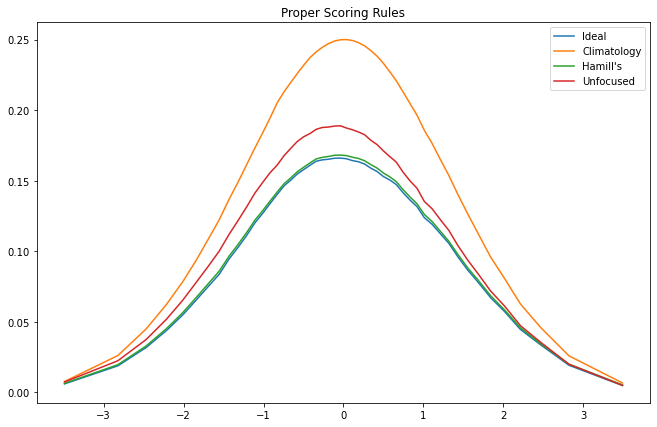

In [14]:
%%time 
BS_Ideal_Curve  = []
BS_Climat_Curve = []
BS_Hamill_Curve = []
BS_Unfoc_Curve  = []

# compute over y grid
y_grid = scipy.stats.norm.ppf(q = [0.01*i for i in range(1, 100, 2)], loc = 0, scale = 1.5)
for y_ in y_grid:
    BS_Ideal_Curve.append(BS_Ideal(y = y_, x_t = x, mu_t = mu))
    BS_Climat_Curve.append(BS_Climat(y = y_, x_t = x))
    BS_Hamill_Curve.append(BS_Hamill(y = y_, x_t = x, mu_t = mu, delta_t = delta, sigma_square_t = sigma_square))
    BS_Unfoc_Curve.append(BS_Unfoc(y = y_, x_t = x, mu_t = mu, delta_t = delta))

# summary frame 
errorCurveFrame = pd.DataFrame(data  = {'Ideal' : BS_Ideal_Curve, 
                                        'Climatology' : BS_Climat_Curve,
                                        'Hamill\'s' : BS_Hamill_Curve, 
                                        'Unfocused' : BS_Unfoc_Curve},
                               index = y_grid)

# plot
errorCurveFrame.plot(title = 'Proper Scoring Rules', figsize = (11, 7))

In [15]:
# Continously-ranked prob. score 
crps_List = [np.mean(BS_Ideal_Curve),
             np.mean(BS_Climat_Curve),
             np.mean(BS_Hamill_Curve),
             np.mean(BS_Unfoc_Curve)]

# logarithmic score 
logS_List = [np.mean(-np.log(f_Ideal(x_t = x, mu_t = mu))),
             np.mean(-np.log(f_Climat(x_t = x))),
             np.mean(-np.log(f_Hamill(x_t = x, mu_t = mu, delta_t = delta, sigma_square_t = sigma_square))),
             np.mean(-np.log(f_Unfoc(x_t = x, mu_t = mu, delta_t = delta)))]

# print
widthFrame = pd.DataFrame(data  = {'LogS' : logS_List, 'CRPS' : crps_List},
                          index = [fc_Name.split(' ')[0] for fc_Name in fc_Names])
widthFrame.index.name = 'Forecaster'

widthFrame.style.set_caption("Average width for the following intervals:")

,LogS,CRPS
Forecaster,,
Ideal,1.418728,0.111631
Climatology,1.862347,0.165027
Hamill's,1.478789,0.113377
Unfocused,1.525384,0.126313


# PIT and ACF of Moments

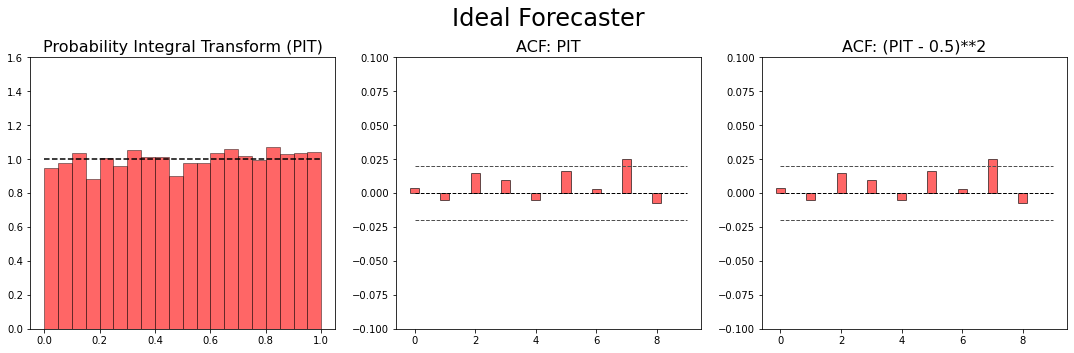

In [35]:
# Plot
fc_CDFs      = [F_Ideal, F_Climat, F_Unfoc, F_Hamill]
fc_Arguments = [[x, mu], [x], [x, mu, delta], [x, mu, delta, sigma_square]]

# panel of 2x2 plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.subplots_adjust(left = 0.1)

# Maximum lag
max_lag      = 10
PIT_values_0 = F_Ideal(*[x, mu])
PIT_values_1 = (PIT_values_0 - 0.5)**2
PIT_values_2 = (PIT_values_0 - 0.5)**3
PIT_Moments  = [PIT_values_0, PIT_values_1, PIT_values_2]
PIT_Names    = ['ACF: PIT', 'ACF: (PIT - 0.5)**2', 'ACF: (PIT - 0.5)**3']


# fill-in histogram plots 
N_bins = 20
i_sum  = 0
ylim   = (0, 1.6)
fig.suptitle('Ideal Forecaster', fontsize = 24, y = 1.02)
for k in range(len(PIT_Moments)):
    # plot
    if(k == 0):
        axs[k].set_title('Probability Integral Transform (PIT)', fontsize = 16)
        axs[k].set_ylim(ylim)
        axs[k].hist(PIT_Moments[k], bins = N_bins, density = True, range=(0, 1), color = "red", 
                      lw=0, alpha= 0.6, edgecolor='black', linewidth = 0.7)
        axs[k].hlines(y = 1, xmin = 0, xmax = 1, color = 'black', linestyles ='dashed')
    else:
        # compute moment
        lags_loc = [pd.Series(PIT_Moments[0]).autocorr(l) for l in range(max_lag)]
        axs[k].set_ylim((-0.1, 0.1))
        # Autcorrelation(*lag)
        axs[k].bar(range(len(lags_loc) - 1), lags_loc[1:], align='center', alpha = 0.6, color = 'r', width = .3, 
                     edgecolor = 'k')
        # title
        axs[k].set_title(PIT_Names[k-1], fontsize = 16)
        # certical lines: 0, +/- significance
        axs[k].hlines(y = 0, xmin = 0, xmax = len(lags_loc)-1, color = 'k', linestyles ='dashed', 
                        linewidth = 1)
        axs[k].hlines(y = 1.96 / np.sqrt(len(PIT_values_0) - max_lag), xmin = 0, xmax = len(lags_loc)-1, color = '#505050', linestyles ='dashed', 
                        linewidth = 1)
        axs[k].hlines(y = - 1.96 / np.sqrt(len(PIT_values_0) - max_lag), xmin = 0, xmax = len(lags_loc)-1, color = '#505050', linestyles ='dashed', 
                        linewidth = 1)

plt.show()

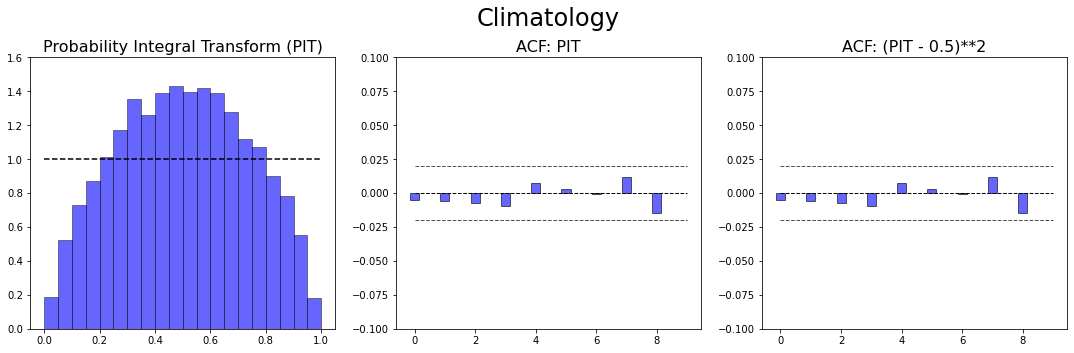

In [36]:
# Plot
fc_CDFs      = [F_Ideal, F_Climat, F_Unfoc, F_Hamill]
fc_Arguments = [[x, mu], [x], [x, mu, delta], [x, mu, delta, sigma_square]]

# panel of 2x2 plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.subplots_adjust(left = 0.1)

# Maximum lag
max_lag      = 10
PIT_values_0 = F_Climat(*[x])
PIT_values_1 = (PIT_values_0 - 0.5)**2
PIT_values_2 = (PIT_values_0 - 0.5)**3
PIT_Moments  = [PIT_values_0, PIT_values_1, PIT_values_2]
PIT_Names    = ['ACF: PIT', 'ACF: (PIT - 0.5)**2', 'ACF: (PIT - 0.5)**3']


# fill-in histogram plots 
N_bins = 20
i_sum  = 0
ylim   = (0, 1.6)
fig.suptitle('Climatology', fontsize = 24, y = 1.02)
for k in range(len(PIT_Moments)):
    # plot
    if(k == 0):
        axs[k].set_title('Probability Integral Transform (PIT)', fontsize = 16)
        axs[k].set_ylim(ylim)
        axs[k].hist(PIT_Moments[k], bins = N_bins, density = True, range=(0, 1), color = "blue", 
                      lw=0, alpha= 0.6, edgecolor='black', linewidth = 0.7)
        axs[k].hlines(y = 1, xmin = 0, xmax = 1, color = 'black', linestyles ='dashed')
    else:
        # compute moment
        lags_loc = [pd.Series(PIT_Moments[0]).autocorr(l) for l in range(max_lag)]
        axs[k].set_ylim((-0.1, 0.1))
        # Autcorrelation(*lag)
        axs[k].bar(range(len(lags_loc) - 1), lags_loc[1:], align='center', alpha = 0.6, color = 'blue', width = .3, 
                     edgecolor = 'k')
        # title
        axs[k].set_title(PIT_Names[k-1], fontsize = 16)
        # certical lines: 0, +/- significance
        axs[k].hlines(y = 0, xmin = 0, xmax = len(lags_loc)-1, color = 'k', linestyles ='dashed', 
                        linewidth = 1)
        axs[k].hlines(y = 1.96 / np.sqrt(len(PIT_values_0) - max_lag), xmin = 0, xmax = len(lags_loc)-1, color = '#505050', linestyles ='dashed', 
                        linewidth = 1)
        axs[k].hlines(y = - 1.96 / np.sqrt(len(PIT_values_0) - max_lag), xmin = 0, xmax = len(lags_loc)-1, color = '#505050', linestyles ='dashed', 
                        linewidth = 1)

plt.show()

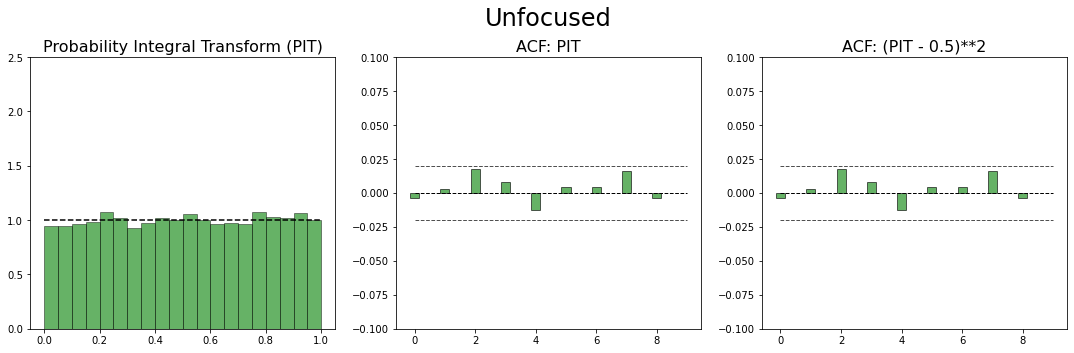

In [37]:
# panel of 2x2 plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.subplots_adjust(left = 0.1)

# Maximum lag
max_lag      = 10
PIT_values_0 = F_Unfoc(*[x, mu, delta])
PIT_values_1 = (PIT_values_0 - 0.5)**2
PIT_values_2 = (PIT_values_0 - 0.5)**3
PIT_Moments  = [PIT_values_0, PIT_values_1, PIT_values_2]
PIT_Names    = ['ACF: PIT', 'ACF: (PIT - 0.5)**2', 'ACF: (PIT - 0.5)**3']


# fill-in histogram plots 
N_bins = 20
i_sum  = 0
ylim   = (0, 2.5)
fig.suptitle('Unfocused', fontsize = 24, y = 1.02)
for k in range(len(PIT_Moments)):
    # plot
    if(k == 0):
        axs[k].set_title('Probability Integral Transform (PIT)', fontsize = 16)
        axs[k].set_ylim(ylim)
        axs[k].hist(PIT_Moments[k], bins = N_bins, density = True, range=(0, 1), color = "green", 
                      lw=0, alpha= 0.6, edgecolor='black', linewidth = 0.7)
        axs[k].hlines(y = 1, xmin = 0, xmax = 1, color = 'black', linestyles ='dashed')
    else:
        # compute moment
        lags_loc = [pd.Series(PIT_Moments[0]).autocorr(l) for l in range(max_lag)]
        axs[k].set_ylim((-0.1, 0.1))
        # Autcorrelation(*lag)
        axs[k].bar(range(len(lags_loc) - 1), lags_loc[1:], align='center', alpha = 0.6, color = 'green', width = .3, 
                     edgecolor = 'k')
        # title
        axs[k].set_title(PIT_Names[k-1], fontsize = 16)
        # certical lines: 0, +/- significance
        axs[k].hlines(y = 0, xmin = 0, xmax = len(lags_loc)-1, color = 'k', linestyles ='dashed', 
                        linewidth = 1)
        axs[k].hlines(y = 1.96 / np.sqrt(len(PIT_values_0) - max_lag), xmin = 0, xmax = len(lags_loc)-1, color = '#505050', linestyles ='dashed', 
                        linewidth = 1)
        axs[k].hlines(y = - 1.96 / np.sqrt(len(PIT_values_0) - max_lag), xmin = 0, xmax = len(lags_loc)-1, color = '#505050', linestyles ='dashed', 
                        linewidth = 1)

plt.show()

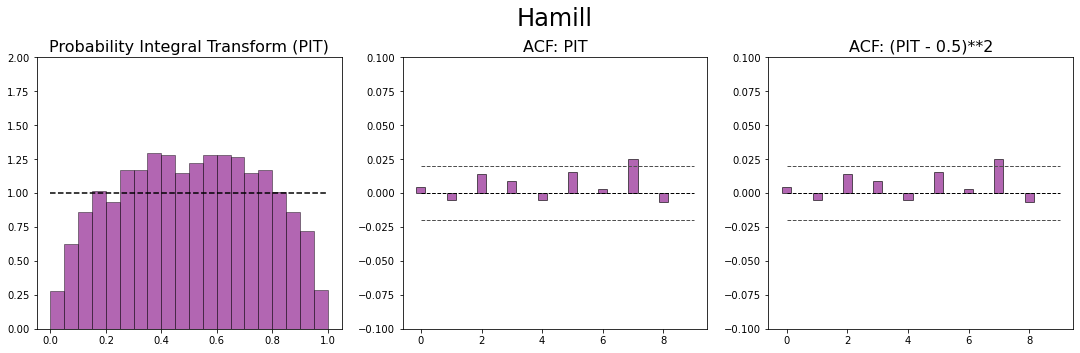

In [38]:
# panel of 2x2 plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.subplots_adjust(left = 0.1)

# Maximum lag
max_lag      = 10
PIT_values_0 = F_Hamill(*[x, mu, delta, sigma_square])
PIT_values_1 = (PIT_values_0 - 0.5)**2
PIT_values_2 = (PIT_values_0 - 0.5)**3
PIT_Moments  = [PIT_values_0, PIT_values_1, PIT_values_2]
PIT_Names    = ['ACF: PIT', 'ACF: (PIT - 0.5)**2', 'ACF: (PIT - 0.5)**3']


# fill-in histogram plots 
N_bins = 20
i_sum  = 0
ylim   = (0, 2.0)
fig.suptitle('Hamill', fontsize = 24, y = 1.02)
for k in range(len(PIT_Moments)):
    # plot
    if(k == 0):
        axs[k].set_title('Probability Integral Transform (PIT)', fontsize = 16)
        axs[k].set_ylim(ylim)
        axs[k].hist(PIT_Moments[k], bins = N_bins, density = True, range=(0, 1), color = "purple", 
                      lw=0, alpha= 0.6, edgecolor='black', linewidth = 0.7)
        axs[k].hlines(y = 1, xmin = 0, xmax = 1, color = 'black', linestyles ='dashed')
    else:
        # compute moment
        lags_loc = [pd.Series(PIT_Moments[0]).autocorr(l) for l in range(max_lag)]
        axs[k].set_ylim((-0.1, 0.1))
        # Autcorrelation(*lag)
        axs[k].bar(range(len(lags_loc) - 1), lags_loc[1:], align='center', alpha = 0.6, color = 'purple', width = .3, 
                     edgecolor = 'k')
        # title
        axs[k].set_title(PIT_Names[k-1], fontsize = 16)
        # certical lines: 0, +/- significance
        axs[k].hlines(y = 0, xmin = 0, xmax = len(lags_loc)-1, color = 'k', linestyles ='dashed', 
                        linewidth = 1)
        axs[k].hlines(y = 1.96 / np.sqrt(len(PIT_values_0) - max_lag), xmin = 0, xmax = len(lags_loc)-1, color = '#505050', linestyles ='dashed', 
                        linewidth = 1)
        axs[k].hlines(y = - 1.96 / np.sqrt(len(PIT_values_0) - max_lag), xmin = 0, xmax = len(lags_loc)-1, color = '#505050', linestyles ='dashed', 
                        linewidth = 1)

plt.show()

## 4. Case-study: Probabilistic Forecasts at the Stateline Wind Eenergy Centre

The paper concludes with the assessment of 2-hour ahead probabilistic wind speed predictions.
This study is replicated, although on a different data basis, in a seperate notebook. 